In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install pandas numpy scikit-learn imbalanced-learn joblib streamlit


In [3]:
# ========== 1. Imports ==========
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [4]:
# ========== 2. Load dataset ==========
df = pd.read_csv('./customer_churn_dataset-testing-master.csv')   # <- change path if needed
print("shape:", df.shape)
df.head()


shape: (64374, 12)


,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,2,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,3,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,4,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,5,53,Female,58,24,9,2,Standard,Annual,533,18,0


In [5]:
# ========== 3. Quick checks ==========
print(df.info())
print("\nMissing values:\n", df.isna().sum())
print("\nDuplicates:", df.duplicated().sum())
print("\nTarget distribution:\n", df['Churn'].value_counts(normalize=True))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64374 entries, 0 to 64373
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CustomerID         64374 non-null  int64 
 1   Age                64374 non-null  int64 
 2   Gender             64374 non-null  object
 3   Tenure             64374 non-null  int64 
 4   Usage Frequency    64374 non-null  int64 
 5   Support Calls      64374 non-null  int64 
 6   Payment Delay      64374 non-null  int64 
 7   Subscription Type  64374 non-null  object
 8   Contract Length    64374 non-null  object
 9   Total Spend        64374 non-null  int64 
 10  Last Interaction   64374 non-null  int64 
 11  Churn              64374 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 5.9+ MB
None

Missing values:
 CustomerID           0
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0

In [6]:
# ========== 4. Preprocessing ==========
# 4.1 Encode categorical columns
le_gender = LabelEncoder()
df['Gender'] = le_gender.fit_transform(df['Gender'])

le_sub = LabelEncoder()
df['Subscription Type'] = le_sub.fit_transform(df['Subscription Type'])

le_contract = LabelEncoder()
df['Contract Length'] = le_contract.fit_transform(df['Contract Length'])

# 4.2 Drop ID
if 'CustomerID' in df.columns:
    df = df.drop('CustomerID', axis=1)

# 4.3 Features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

print("Features:", X.columns.tolist())


Features: ['Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Subscription Type', 'Contract Length', 'Total Spend', 'Last Interaction']


In [7]:
# ========== 5. Train/test split ==========
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Shapes:", X_train.shape, X_test.shape)


Shapes: (51499, 10) (12875, 10)


In [8]:
# ========== 6. Handle imbalance with SMOTE on training set ==========
print("Before SMOTE:", y_train.value_counts())
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("After SMOTE:", pd.Series(y_train_res).value_counts())


Before SMOTE: Churn
0    27105
1    24394
Name: count, dtype: int64
After SMOTE: Churn
0    27105
1    27105
Name: count, dtype: int64


In [9]:
# ========== 7. Scale numeric features ==========
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)


In [10]:
# ========== 8. Define models and hyperparameters ==========
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    
}

param_grids = {
    'LogisticRegression': {'C': [0.01, 0.1, 1, 10]},
    'RandomForest': {'n_estimators':[100,200], 'max_depth':[None,10,20], 'min_samples_split':[2,5]},
    'GradientBoosting': {'n_estimators':[100,200], 'learning_rate':[0.01,0.1], 'max_depth':[3,5]},
    
}


In [11]:
# ========== 9. GridSearchCV to find best model ==========
best_models = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\nRunning GridSearch for {name} ...")
    grid = GridSearchCV(model, param_grids[name], cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
    grid.fit(X_train_res, y_train_res)
    print(f"Best {name} params: {grid.best_params_}")
    print(f"Best {name} CV accuracy: {grid.best_score_:.4f}")
    best_models[name] = grid.best_estimator_



Running GridSearch for LogisticRegression ...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best LogisticRegression params: {'C': 0.1}
Best LogisticRegression CV accuracy: 0.8275

Running GridSearch for RandomForest ...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best RandomForest params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best RandomForest CV accuracy: 0.9975

Running GridSearch for GradientBoosting ...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best GradientBoosting params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best GradientBoosting CV accuracy: 0.9983


In [12]:
# ========== 10. Evaluate best models on the test set ==========
results = []
for name, model in best_models.items():
    # Train on resampled+scaled training data if needed (GridSearch already fit)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    roc = None
    try:
        probs = model.predict_proba(X_test_scaled)[:,1]
        roc = roc_auc_score(y_test, probs)
    except:
        try:
            probs = model.decision_function(X_test_scaled)
            roc = roc_auc_score(y_test, probs)
        except:
            roc = None
    print(f"\nModel: {name}")
    print("Accuracy:", acc)
    if roc:
        print("ROC AUC:", roc)
    print(classification_report(y_test, y_pred))
    results.append((name, model, acc))



Model: LogisticRegression
Accuracy: 0.8249320388349515
ROC AUC: 0.9017472041887371
              precision    recall  f1-score   support

           0       0.85      0.82      0.83      6776
           1       0.80      0.83      0.82      6099

    accuracy                           0.82     12875
   macro avg       0.82      0.83      0.82     12875
weighted avg       0.83      0.82      0.83     12875


Model: RandomForest
Accuracy: 0.9990679611650486
ROC AUC: 0.999997289895783
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6776
           1       1.00      1.00      1.00      6099

    accuracy                           1.00     12875
   macro avg       1.00      1.00      1.00     12875
weighted avg       1.00      1.00      1.00     12875


Model: GradientBoosting
Accuracy: 0.9999223300970874
ROC AUC: 0.9999999758026409
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     

In [13]:
    # ========== 11. Choose best model ==========
results_sorted = sorted(results, key=lambda x: x[2], reverse=True)
best_name, best_model, best_acc = results_sorted[0]
print(f"\nBest model: {best_name} with accuracy {best_acc:.4f}")



Best model: GradientBoosting with accuracy 0.9999


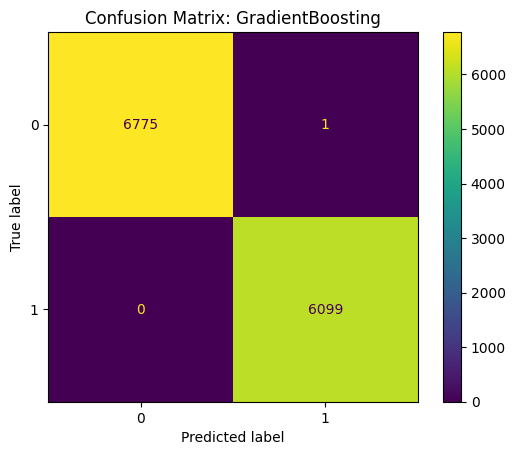

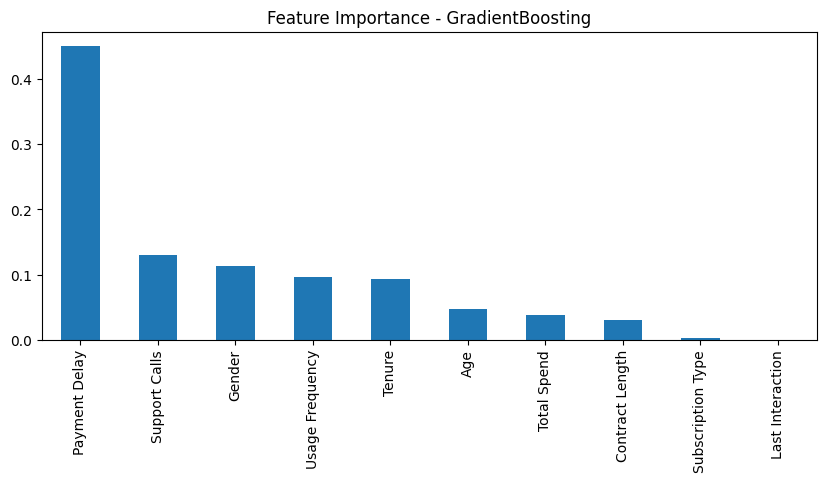

In [14]:
# ========== 12. Confusion matrix and feature importance (for tree models) ==========
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion matrix
y_pred_best = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f'Confusion Matrix: {best_name}')
plt.show()

# Feature importance if available
if hasattr(best_model, 'feature_importances_'):
    importances = pd.Series(best_model.feature_importances_, index=X.columns)
    importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,4))
    plt.title(f'Feature Importance - {best_name}')
    plt.show()


In [15]:
# ========== 13. Save best model + scaler + label encoders ==========
joblib.dump(best_model, 'best_churn_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le_gender, 'le_gender.pkl')
joblib.dump(le_sub, 'le_subscription.pkl')
joblib.dump(le_contract, 'le_contract.pkl')
print("Saved: best_churn_model.pkl, scaler.pkl, and encoders.")


Saved: best_churn_model.pkl, scaler.pkl, and encoders.
